# `xaitk-saliency` Increment 0 Demo

## Table Of Contents
* [Example T&E Workflow (with XAI)](#te-workflow)
* [Environment Setup](#environment-setup)
* [Using a JATIC Object Detector with `xaitk-saliency`](#obj-det-protocol)
    * [Instantiate Protocol-Based Detector](#instantiate-protocol-based-detector)
    * [Transform Protocol-Based Detector](#transform-protocol-based-detector)
    * [Use the Detector as "Normal"](#use-detector-as-normal)
        * [Get Reference Detections](#get-reference-detections)
        * [Generate Saliency Maps](#generate-saliency-maps)
* [Saliency Map Uses](#saliency-map-uses)
* [`xaitk-saliency` GUI](#xaitk-gui)
* [Key Takeaways](#key-takeaways)
* [Undemonstrated Increment 0 Work](#undemonstrated-increment-0-work)

## Example T&E Workflow (with XAI) <a name="te-workflow"></a>

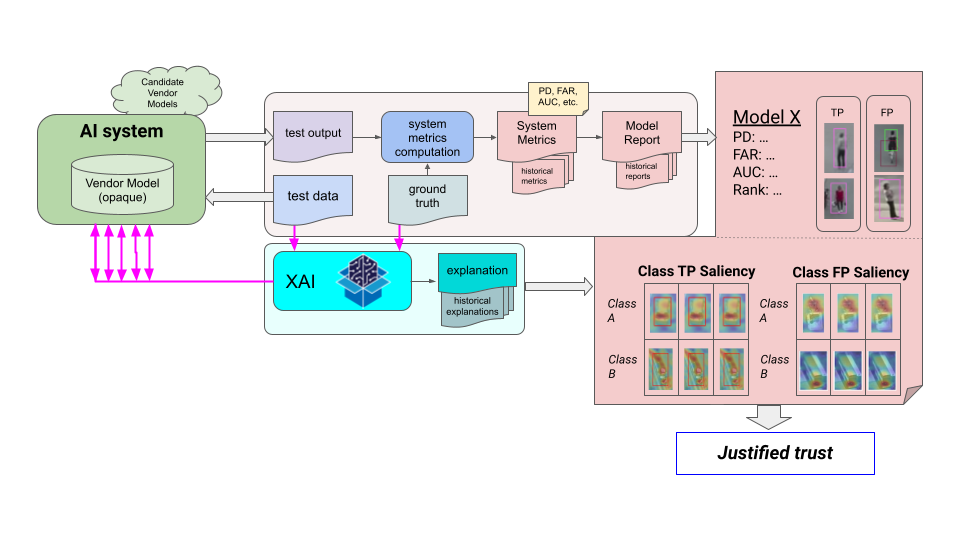

Current evaluation / validation & verification of AI system performance is typically limited to:
- sampling predictions / output from the model and comparing to ground truth
- observation of model impact on overall system metrics

It is difficult to predict how an algorithm will behave on new data under different conditions, scenes, or sensing characteristrics

XAI illuminates model behavior independent of system metrics:
- additional information to help establish justified trust - an operator should know when the AI can be trusted and when it cannot
- determine justified trust for two comparable models, with preference given to the more justified, explainable model
- address DoD Ethical AI Principles of **Traceability and Reliability**

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing xaitk-jatic...")
!{sys.executable} -m pip install -q ..
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Installing smqtk-detection...")
!{sys.executable} -m pip install -qU smqtk-detection[centernet]
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing torchvision...")
!{sys.executable} -m pip -q install torchvision
print("Installing tqdm...")
!{sys.executable} -m pip -q install tqdm
print("Installing hydra-zen...")
!{sys.executable} -m pip -q install hydra-zen
print("Installing xaitk-saliency-demo...")
!{sys.executable} -m pip -q install xaitk-saliency-demo
print("Installing pandas...")
!{sys.executable} -m pip -q install "pandas<2.0.0"
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing xaitk-jatic...
Installing xaitk-saliency...
Installing smqtk-detection...
Installing torch...
Installing torchvision...
Installing tqdm...
Installing hydra-zen...
Installing xaitk-saliency-demo...
Installing pandas...
Installing headless OpenCV...
Done!


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import time
import torch
from PIL import Image

# pinned to jatic_toolbox version 0.0.1
from jatic_toolbox.interop.smqtk import CenterNet

from xaitk_jatic.interop.object_detection import JATICDetector
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import RandomGridStack

from demo_utils import ( # type: ignore
    dets_to_mats, 
    display_sal_maps, 
    get_image,
    show_dets
)

# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

## Using a JATIC Object Detector with `xaitk-saliency` <a name="obj-det-protocol"></a>

The JATIC object detector protocol allows us to define an easy-to-use interface that provides support for detectors following the protocol. A demonstration of using this interface follows.

### Instantiate Protocol-Based Detector <a name="instantiate-protocol-based-detector"></a>

First, we need a detector that uses the JATIC object detection protocol.

In [3]:
protocol_detector = CenterNet.from_pretrained("resnet50", use_cuda=torch.cuda.is_available())

### Transform Protocol-Based Detector <a name="transform-protocol-based-detector"></a>

Now that we have our protocol-based detector, we can wrap it so that it can be used directly with `xaitk-saliency`.

In [4]:
detector = JATICDetector(protocol_detector)

### Use the Detector as "Normal" <a name="use-detector-as-normal"></a>

Now the detector can be used just like it is a regular `xaitk-saliency` detector implementation.

#### Get Reference Detections <a name="get-reference-detections"></a>

We'll use a single example image from the VisDrone test dataset.

In [5]:
img = np.asarray(get_image(
    url='https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download', 
    img_name='visdrone_img.jpg',
))

First, we'll generate detections on this image with our detector.

In [6]:
# Get detections from our detector
dets = list(detector([img]))[0]

For this example, we'll only generate saliency maps on the first few detections.

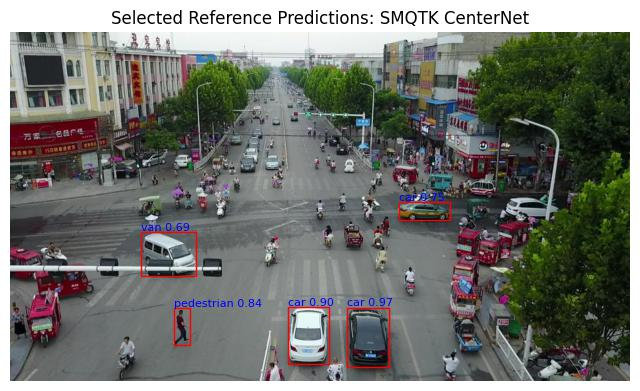

In [7]:
# Get the first few detections for saliency map generation
num_reference_dets = 5
centernet_ref_dets = list(dets)[:num_reference_dets]

# Display reference detections
fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title("Selected Reference Predictions: SMQTK CenterNet")
axs.imshow(img)
axs.axis("off")
show_dets(axs, centernet_ref_dets, thresh=0.4, show_labels=True)

#### Generate Saliency Maps <a name="generate-saliency-maps"></a>

The `GenerateObjectDetectorBlackboxSaliency` interface requires our reference detections to be split into separate bounding boxes and scores inputs, both as numpy arrays, so we'll now prepare our inputs.

In [8]:
centernet_bboxes, centernet_scores = dets_to_mats(centernet_ref_dets)

We'll use the `RandomGridStack` implementation to generate our saliency maps. To reduce computation time, our selected saliency parameters will result in fairly coarse saliency maps. Modifying these parameters (`n` and `s`) will increase computation time, but may result in more meaningful saliency maps.

In [9]:
sal_generator = RandomGridStack(
    n=150,      # number of masks
    s=(7,7),    # occlusion grid cell size in pixels
    p1=0.7,     # probability of not occluding cell
    threads=8,  # execution threads
    seed=42,    # seed for replicable results
)

# gray average of VisDrone
fill = [95, 96, 93]
sal_generator.fill = fill

In [10]:
print("Generating CenterNet saliency maps...")
start = time.time()
centernet_sal_maps = sal_generator(
    img,
    centernet_bboxes,
    centernet_scores,
    detector
)
end = time.time()
print(f"Done in {end-start:.2f}s")

Generating CenterNet saliency maps...
Done in 14.62s


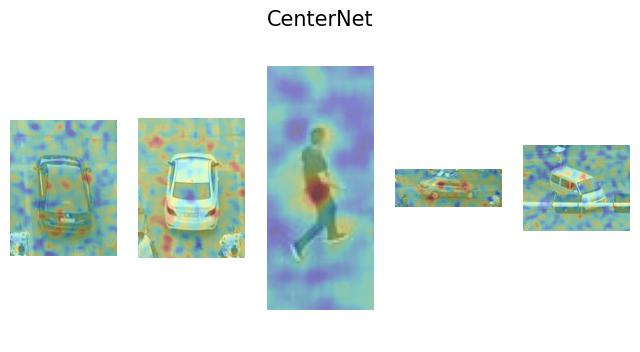

In [11]:
display_sal_maps(centernet_sal_maps, centernet_bboxes, img, "CenterNet")

## Saliency Maps Uses <a name="saliency-map-uses"></a>

With saliency map capability, a greater level of model understanding can be achieved. For example, saliency maps may be helpful in diagnosing potential spurious correlations. Additionally, saliency maps can be used to compare performance across models:

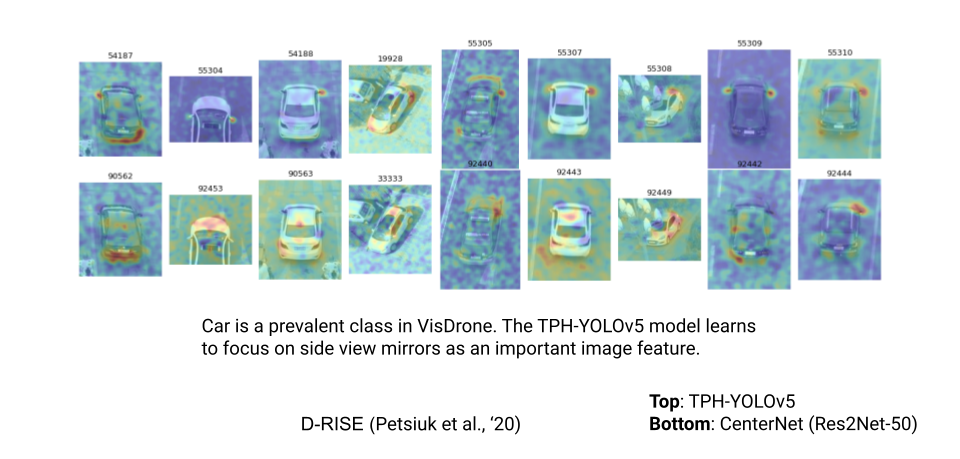

Saliency maps can reveal patterns that otherwise may be difficult or impossible to identify.

Note: A more in depth exploration of the TPH-YOLOv5 model can be found in [this notebook](https://github.com/XAITK/xaitk-saliency/blob/master/examples/ModelComparisonWithSaliency.ipynb).

## `xatik-saliency` GUI <a name="xaitk-gui"></a>

If a more interactive session is desired, `xaitk-saliency` can also be used with its `trame` GUI.

In [12]:
from xaitk_saliency_demo.app.jupyter import show as demo_xaitk # type: ignore

demo_xaitk(height=1000)

/home/local/KHQ/emily.veenhuis/miniconda3/envs/test-demo/lib/python3.8/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():
/home/local/KHQ/emily.veenhuis/miniconda3/envs/test-demo/lib/python3.8/site-packages/altair/utils/core.py:185: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  warnings.warn(
/home/local/KHQ/emily.veenhuis/miniconda3/envs/test-demo/lib/python3.8/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():
/home/local/KHQ/emily.veenhuis/miniconda3/envs/test-demo/lib/python3.8/site-packages/altair/utils/core.py:185: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  warnings.warn(
/home/local/KHQ/emily.veenhuis/miniconda3/en

## Key Takeaways <a name="key-takeaways"></a>

- Easy to handle JATIC object detectors with little modification to `xaitk-saliency`
  - Integration will allow for easy model evaluation as the collection of JATIC object detectors grows
- `xatik-saliency`'s support of both a python-based API and an interactive UI interface allows for ease of use across multiple categories of users

## Undemonstrated Increment 0 Work <a name="undemonstrated-increment-0-work"></a>

- MLflow integration for tracking XAI artifacts across experiments
- Scaling XAI computation via distributed inference with PyTorch Lightning
- Gradio integration for even more ways to interact with `xaitk-saliency`